# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.5.1


# Preparing Training and Test Sets

In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    #image_dirs is image directories, having path of the list of images, tranform is used for data augmenatation in training datset. For test datset, we will convert images into tensors, and normalize values that we have in input images
    def  __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('.png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        #Let's use dictionary, to keep track of all of these images, of differnet classes
        self.images = {}
        # Let's save class names as well
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            # dictionary, with value being list of images, which belongs to that class
            self.images[c] = get_images(c)
            
            self.image_dirs = image_dirs
            self.transform = transform
            
    
    def __len__(self):
        # It's number of images of all the three classes combined i.e., all the lengths of different classes, will be added together.
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        # to avoid class imbalnce in training dataset, as covid has just 216 images, whereas, others have large number of images
        class_name = random.choice(self.class_names)
        # index is remainder of no of examples of the specific class. it can be from 0 to 299
        # index can be out of bound. Supoose index is 300, and length of images of this class is 200. Then , index is out of bounds. But, since we're taking remainder of the class, we're left with just 100.
        # this logic is just to avoid any out of bounds index value.
        index = index % len(self.images[class_name])
        # list of images, taht belong to particular class
        image_name = self.images[class_name][index]
        # join image directory of this class, with image name
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        # WE're loading image and converting it to RGB, before opening it. SInce, images are balck n white.
        # If we would have been creating CNN from scratch , tehn, we won't have to use RGB, we can just directly use channel value= 1 in neural network. 
        # But, we 're going to use Resnet18, and we're going to use pretrained weights of Resnet18,which are trained on ImageNet dataset.
        #Since, we 're using Resnet18, the input is already defined, and we need to have 3 channels- 'RGB'
        
        image = Image.open(image_path).convert('RGB')
        # Will return transformed version of image, as well as label. Since, Pytorch don't understnad PIL image, thus, they need to be converted to tensors, that's what transform does.
        return self.transform(image), self.class_names.index(class_name)
        

# Image Transformations

In [4]:
# create transformtaion of training and test dataset
train_transform = torchvision.transforms.Compose([
    # convert images to same size- 224*224, since we're using pretrained model- resnet, else, we would have used custom size as well.
    torchvision.transforms.Resize(size=(224, 224)),
    # tHen, apply randomhorizontalflip, for data augmentation- collecting more data, from already presnt data.
    # purpose of randomhorizontalflip is that if we horizontally flip the image from normal class, then, it should be part of normal class only, even after flipping.
    torchvision.transforms.RandomHorizontalFlip(),
    # next, will convert image to tensor, so that, it can be used for computaion by pytorch.
    torchvision.transforms.ToTensor(),
    # then, normalize data to specific range, which is used when Resnet model was trained on imagenet dataset.
    # son, inorder to take advantage of transfer learning, and use pretrained weights, we have to ensure that our input data is normalized in the same way, that the imagenet datset was normalized.
    # so, we can set mean and standard deviation for different channels in this tensor.
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std= [0.229, 0.224, 0.225])
    
])

In [5]:
# here, we won't do any horizontalflip on data. rest, remains the same.
test_transform = torchvision.transforms.Compose([
    # convert images to same size- 224*224, since we're using pretrained model- resnet, else, we would have used custom size as well.
    torchvision.transforms.Resize(size=(224, 224)),
    # next, will convert image to tensor, so that, it can be used for computaion by pytorch.
    torchvision.transforms.ToTensor(),
    # then, normalize data to specific range, which is used when Resnet model was trained on imagenet dataset.
    # son, inorder to take advantage of transfer learning, and use pretrained weights, we have to ensure that our input data is normalized in the same way, that the imagenet datset was normalized.
    # so, we can set mean and standard deviation for different channels in this tensor.
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std= [0.229, 0.224, 0.225])
    
])

# Prepare DataLoader

In [6]:
#dataloader are essentially either maps or iterators, which are going to use the dataset objects, and fetch examples and give it to the model, during the cleaning process.
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [7]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [9]:
# in order to use DataLoader, we have to create DataLoader class from data module, in PyTorch utilities.
batch_size = 6

# DataLoader for train-
# shuffle=True, means indices are shuffled, and they're not going to be loaded in sequence/index
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                      shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                      shuffle=True)
# let's take a look at number of batch created-
print('Numebr of training batches', len(dl_train))
print('Numebr of testing batches', len(dl_test))
# that makes sense, because we have 2820 tarining datsets and 90 test datasets
# SO, these are iterators, which are going to iterate over teh datset, and give us the examples and labels,of this batch size.


Numebr of training batches 470
Numebr of testing batches 15


# Data Visualization

In [10]:
# craete a helper function, to display images, that will also use later in training loop. 
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    # SInce, we have a batch_size = 6. Thus,will display 6 images at a time.
    for i, image in enumerate(images):
        plt.subplot(1,6, i + 1, xticks = [], yticks = [])
        # convert tensor image to numpy multidimensional array, and transpose it in a way that axis 0 be the last one.since Resnet18 has channel first. Thus, here too first channel is there. Then, comes width and height.
        # set axis 1 to axis 0, axis 2 to axis 1 and axis 0 to axis 2 i.e., channel 1 converted to channel last
        image = image.numpy().transpose((1, 2, 0))
        # in transformation , we also normalized values. SO, here will do opposite i.e., converting mean and std to numpy arrays.
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        # And now will convert image pixel values to original values, the way they were before normalization.
        image = image * std + mean
        # And then, will clip values between 0 and 1
        image = np.clip(image, 0., 1.)
        #display image
        plt.imshow(image)
        
        # will use x label, to show ground truth and y label to show prediction
        # if prediction is correct, then, it will be displayed in green. If it's wrong, it'll be displayed in Red
        col = 'green' if preds[i] == labels[i] else 'red'
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()
        

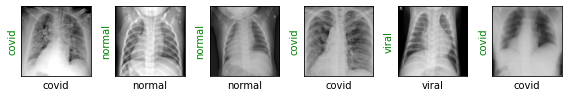

In [14]:
# fetch images over a batch for train datset
images, labels = next(iter(dl_train))
show_images(images, labels, labels) # here, take predictions as labels only

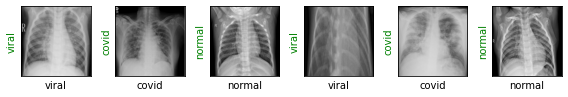

In [16]:
# fetch images over a batch for train datset
images, labels = next(iter(dl_test))
show_images(images, labels, labels) # here, take predictions as labels only

# Creating the Model

In [17]:
 # There are various resnet moels, but, renet18 is a smaller model, whih can be trained quickly, and it still gives us pretty decent results.
#pretrained=True, since we're using pretrained weights from the ImageNet training
resnet18 = torchvision.models.resnet18(pretrained=True)
# And in Pytorch, can print out model object
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# from the above model, we can see taht Resnet18 model was trained on ImageNet dataset, and ImageNet datset has 1000 classes. So, that won't work for us. SInce, we have just 3 output classes.
# So, change teh last fully connected layer, that Resnet18 has, to three output features.
# as can be seen above, fc is last layer
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
# Since, we're doing Classification, thus, will use appropriate loss function as CrossEntriopyLoss, and using AdamOptimizations
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch. optim.Adam(resnet18.parameters(), lr=3e-5)
# lr i.e., learning rate can be checked by performing hyperpaerametr optimization, running them for a few epochs and then, compare.


In [21]:
def show_preds():
    # evaluate resnet18 model
    resnet18.eval()
    # to iterate over test model, to get images and labels
    images, labels = next(iter(dl_test))
    # then, will get output
    outputs = resnet18(images)
    # get indices of max values for all the outputs, and those will be our predictions, and using dimension=1 i.e., output values, since, dimension 0 corresponds to numebr of examples.
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

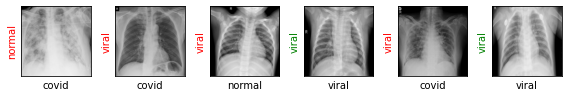

In [23]:
show_preds() # model is not trained yet. We're just using pretrained weights here.

# Training the Model

In [28]:
def train(epochs):
    # Within each epoch, there will be more iterations for each training step
    # And, after a certain number of training steps within each epoch, will evaluate model, and see the accuracy we're getting
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/ {epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet18.train()
        
        for train_step, (images, labels) in enumerate(dl_train):
            # let's refresh optimizer, and set it to 0's
            optimizer.zero_grad()
            outputs = resnet18(images)
            # loss is loss_fn defined before, cross_entropy_loss
            loss = loss_fn(outputs, labels)
            # once we get loss, we take gradients tep, and the way to do taht is taking step in backward direction
            # THis is backpropogation
            loss.backward()
            # Then, will use optimizer, to update all parameter values, from the model.
            optimizer.step() # to update all parameter values
            # 
            train_loss += loss.item()
            # At every 20th step, will evaluate the model
            if train_step % 20 == 0:
                print('Evaluating at step:', train_step)
                #Then, calulate validation accuracy
                acc = 0.
                val_loss = 0.
                # Then, resnet model will set to evaluation mode.
                resnet18.eval()
                
                #for 
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    # We have indices as our prediction, returned from torch.max
                    _, preds = torch.max(outputs, 1) # here, dim- 11- corresponds to avlues and dim- 0  is number of examples
                    acc += sum((preds == labels).numpy()) # add to accuracy, number of correct predictions we have
                    # SO, value staht will be True are 's and those that are False are print('='*20)'s. And, all of them summed up together.
                # since we have 90 test samples, and epochs = 6 thus,  there were 15 validation steps. So, thus dividing by total number of steps
                val_loss /= (val_step + 1)
                # sum of correct predictions, divided by total number of smaples i.e., 90 for test dataset
                acc = acc / len(test_dataset)
                print(f'Val loss:{val_loss: .4f}, Acc:{acc: .4f} ')
                show_preds()
                
                resnet18.train()
                
                if acc > .95:
                    print('Performance condition satisfied')
                    return
        # Get training loss for each step
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss: .4f}')
        

Starting training..
Starting epoch 1/ 1
Evaluating at step: 0
Val loss: 0.9799, Acc: 0.4667 


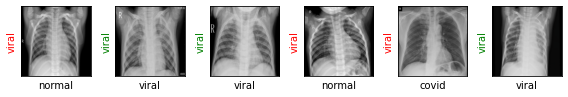

Evaluating at step: 20
Val loss: 0.5615, Acc: 0.8000 


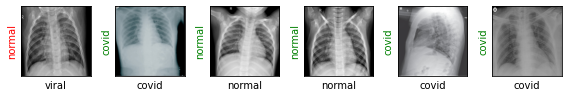

Evaluating at step: 40
Val loss: 0.2971, Acc: 0.9111 


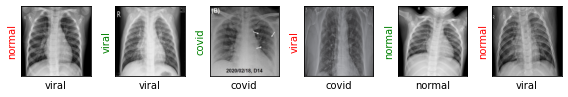

Evaluating at step: 60
Val loss: 0.3278, Acc: 0.8667 


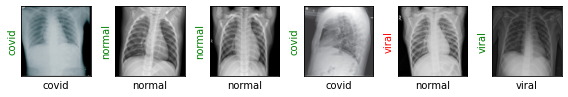

Evaluating at step: 80
Val loss: 0.1867, Acc: 0.9444 


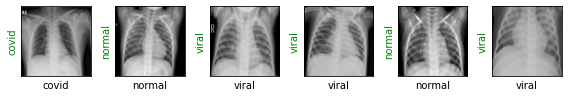

Evaluating at step: 100
Val loss: 0.1763, Acc: 0.9333 


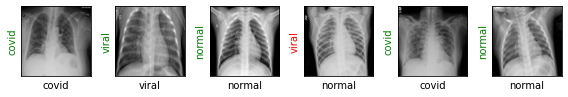

Evaluating at step: 120
Val loss: 0.1594, Acc: 0.9444 


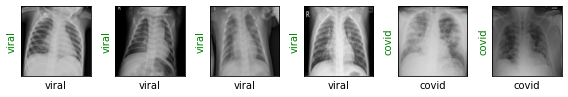

Evaluating at step: 140
Val loss: 0.2103, Acc: 0.9000 


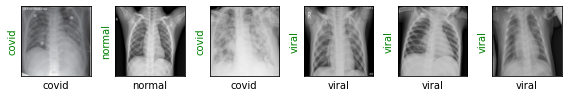

Evaluating at step: 160
Val loss: 0.1590, Acc: 0.9444 


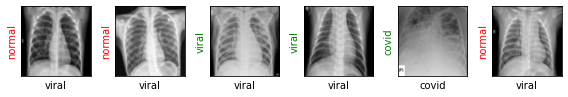

Evaluating at step: 180
Val loss: 0.1905, Acc: 0.9333 


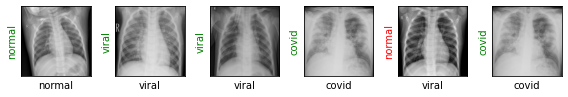

Evaluating at step: 200
Val loss: 0.1861, Acc: 0.9222 


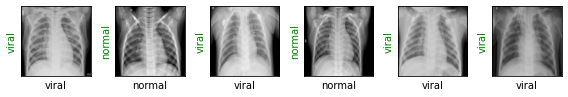

Evaluating at step: 220
Val loss: 0.1064, Acc: 0.9778 


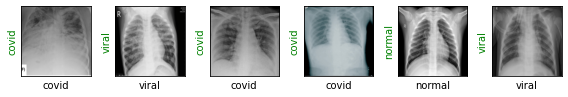

Performance condition satisfied


In [29]:
train(epochs=1)

# Final Results

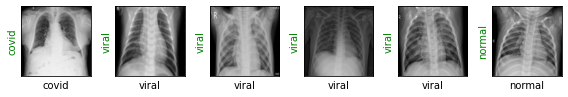

In [31]:
show_preds()